<a href="https://colab.research.google.com/github/andreina-covi/DataNLP/blob/main/ProyectoSinchi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificacion de idiomas originarios de Bolivia

## Descripcion


In [ ]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
from sklearn.utils import shuffle
from time import time
import string
import codecs
import copy
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, roc_auc_score

In [ ]:
# Para obtener datos replicables establecemos una semilla para la aleatoridad

seed_value= 12321 
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [ ]:
dataQuechua = pd.read_csv('https://raw.githubusercontent.com/andreina-covi/DataNLP/main/Quechua.csv')
dataEspaniol = pd.read_csv('https://raw.githubusercontent.com/andreina-covi/DataNLP/main/Espaniol.csv')

In [ ]:
dataQuechua.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Texto   2534 non-null   object
 1   Idioma  2535 non-null   object
dtypes: object(2)
memory usage: 39.7+ KB


In [ ]:
dataEspaniol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Texto   1091 non-null   object
 1   Idioma  1091 non-null   object
dtypes: object(2)
memory usage: 17.2+ KB


In [ ]:
dataEspaniolKaggle = pd.read_csv('https://raw.githubusercontent.com/andreina-covi/DataNLP/main/dataset_kaggle.csv')
dataEspaniolKaggle = dataEspaniolKaggle[dataEspaniolKaggle.language == 'Spanish']
dataEspaniolKaggle.head()

,Text,language
21,en navidad de poco después de que interpretó ...,Spanish
115,según el censo de []​ había personas residien...,Spanish
162,en la copa mundial de fútbol sub- de pitó los...,Spanish
191,ally y buttons encuentran el descodificador y ...,Spanish
195,los primeros habitantes se establecieron cerca...,Spanish


Obtencion de frases en espaniol y renombramiento de las columnas del dataset de Kaggle

In [ ]:
dataEspaniolKaggle["language"] = 'Español'
dataEspaniolKaggle= dataEspaniolKaggle.rename(columns = {'Text': 'Texto', 'language': 'Idioma'}, inplace = False)

In [ ]:
# Funcion para reemplazar caracteres especiales diferentes al idioma espaniol
def reemplazar_caracteres_chinos(texto):
    nuevo_texto = texto
    nuevo_texto = re.sub("[^\u0000-\u05C0\u2100-\u214F]+", '', nuevo_texto)
    return nuevo_texto

def listar_caracteres_unicos(column):
    dict_bytes = {}
    for string in column:
        for c in string:
            dict_bytes[ord(c)] = c
    return dict_bytes

def reemplazar_caracteres_diferentes(texto, dictionary):
    return texto.translate(dictionary)

In [ ]:
# Imprimir los valores numericos y sus correspondientes caracteres
dict_caracteres = listar_caracteres_unicos(dataEspaniolKaggle['Texto'])
lista_tuplas = np.array([tuple(item) for index, item in enumerate(dict_caracteres.items())])
tupla_caracteres = np.reshape(lista_tuplas, (87, 4))
print(tupla_caracteres)

[['101' 'e' '110' 'n']
 ['32' ' ' '97' 'a']
 ['118' 'v' '105' 'i']
 ['100' 'd' '112' 'p']
 ['111' 'o' '99' 'c']
 ['115' 's' '117' 'u']
 ['233' 'é' '113' 'q']
 ['116' 't' '114' 'r']
 ['243' 'ó' '108' 'l']
 ['102' 'f' '237' 'í']
 ['103' 'g' '109' 'm']
 ['225' 'á' '121' 'y']
 ['104' 'h' '98' 'b']
 ['250' 'ú' '91' '[']
 ['93' ']' '8203' '\u200b']
 ['107' 'k' '178' '²']
 ['122' 'z' '45' '-']
 ['120' 'x' '106' 'j']
 ['241' 'ñ' '263' 'ć']
 ['252' 'ü' '34' '"']
 ['171' '«' '187' '»']
 ['119' 'w' '232' 'è']
 ['242' 'ò' '363' 'ū']
 ['8211' '–' '191' '¿']
 ['63' '?' '8220' '“']
 ['8221' '”' '176' '°']
 ['8242' '′' '8243' '″']
 ['126' '~' '186' 'º']
 ['170' 'ª' '8216' '‘']
 ['8217' '’' '224' 'à']
 ['314' 'ĺ' '1575' 'ا']
 ['1587' 'س' '1578' 'ت']
 ['1583' 'د' '1593' 'ع']
 ['1610' 'ي' '1609' 'ى']
 ['21253' '包' '36774' '辦']
 ['23130' '婚' '23035' '姻']
 ['30450' '盲' '161' '¡']
 ['12399' 'は' '12420' 'や']
 ['12406' 'ぶ' '12373' 'さ']
 ['322' 'ł' '380' 'ż']
 ['21016' '刘' '26174' '显']
 ['33521' '英' '228' 'ä']

In [ ]:
# Imprimir solo los caracteres del dataset
lista_caracteres = dict_caracteres.values()
lista_caracteres = list(lista_caracteres)
print(np.array(lista_caracteres))

['e' 'n' ' ' 'a' 'v' 'i' 'd' 'p' 'o' 'c' 's' 'u' 'é' 'q' 't' 'r' 'ó' 'l'
 'f' 'í' 'g' 'm' 'á' 'y' 'h' 'b' 'ú' '[' ']' '\u200b' 'k' '²' 'z' '-' 'x'
 'j' 'ñ' 'ć' 'ü' '"' '«' '»' 'w' 'è' 'ò' 'ū' '–' '¿' '?' '“' '”' '°' '′'
 '″' '~' 'º' 'ª' '‘' '’' 'à' 'ĺ' 'ا' 'س' 'ت' 'د' 'ع' 'ي' 'ى' '包' '辦' '婚'
 '姻' '盲' '¡' 'は' 'や' 'ぶ' 'さ' 'ł' 'ż' '刘' '显' '英' 'ä' 'в' 'б' 'ž' '•' 'â'
 'ô' '—' 'ل' 'ج' 'ن' 'ة' 'أ' 'و' 'م' 'ب' 'ر' 'ض' 'ز' 'ئ' '아' '이' '언' '키'
 '드' 'ß' 'ã' '$' 'ö' 'š' 'ç' '服' '部' '緑' '地' '都' '市' '化' '植' '物' '園' '^'
 '|' 'ὅ' 'μ' 'ο' 'ι' 'ς' 'σ' 'τ' 'ά' '叫' 'べ' 'ō' '†' 'л' 'а' 'д' 'е' 'и'
 'ц' '仲' '人' '家' '柄' '魔' '法' '少' '女' '育' '成' '計' '画' '…' '>' '<' 'β' 'п'
 'о' 'т' 'ч' 'с' 'к' 'й' 'з' 'ю' 'ё' 'н' 'ы' 'у' 'г']


In [ ]:
# a partir del caracter 250 para adelante son caracteres especiales y de otros idiomas por tanto se reemplazan
dict_caracteres = listar_caracteres_unicos(dataEspaniolKaggle['Texto'])
dict_reemplazo = {}
for key in dict_caracteres.keys():
    if(key > 252 and key != 8217):
        dict_reemplazo[key] = None
dataEspaniolKaggle['Texto'] = dataEspaniolKaggle.apply(lambda x: reemplazar_caracteres_diferentes(x['Texto'], dict_reemplazo), axis=1)

In [ ]:
lista_caracteres = listar_caracteres_unicos(dataEspaniolKaggle['Texto']).values()
lista_caracteres = list(lista_caracteres)
print(np.array(lista_caracteres))

['e' 'n' ' ' 'a' 'v' 'i' 'd' 'p' 'o' 'c' 's' 'u' 'é' 'q' 't' 'r' 'ó' 'l'
 'f' 'í' 'g' 'm' 'á' 'y' 'h' 'b' 'ú' '[' ']' 'k' '²' 'z' '-' 'x' 'j' 'ñ'
 'ü' '"' '«' '»' 'w' 'è' 'ò' '¿' '?' '°' '~' 'º' 'ª' '’' 'à' '¡' 'ä' 'â'
 'ô' 'ß' 'ã' '$' 'ö' 'ç' '^' '|' '>' '<']


In [ ]:
# concatenar los datos de espaniol
framesEspaniol = [dataEspaniol, dataEspaniolKaggle]
dataEspaniol = pd.concat(framesEspaniol)

In [ ]:
# obtener informacion del conjunto de datos quechua
dataQuechua.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Texto   2534 non-null   object
 1   Idioma  2535 non-null   object
dtypes: object(2)
memory usage: 39.7+ KB


In [ ]:
# obtener informacion del conjunto de datos espaniol
dataEspaniol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 21997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Texto   2091 non-null   object
 1   Idioma  2091 non-null   object
dtypes: object(2)
memory usage: 49.0+ KB


Crear un solo dataset

In [ ]:
# unir ambos idiomas
frames = [dataQuechua, dataEspaniol]
data = pd.concat(frames)

In [ ]:
# Se mezclan los datos tanto de Quechua como de espaniol
df = shuffle(data, random_state=seed_value)
df.head(10)

,Texto,Idioma
917,Makiykita paqakuy manaraq sirbanaykipaq,Quechua
281,pipaqtaq,Quechua
718,¿Dónde sucedió el accidente?,Español
1871,Wasimasiypa wakankunan chayta ruwanku,Quechua
856,Todos le tenemos miedo.,Español
375,Uno,Español
20930,regulación en los organismos reguladores un di...,Español
262,¿Maydiyataq tikrakamuyanki?,Quechua
1268,Mesa de partisqa tawapacha kimsa chunkayuqkama...,Quechua
138,urku,Quechua


# Ingenieria de caracteristicas (Feature engineering)

In [ ]:
# filtrando las columnas que tienen valores nulos
x = df.columns[df.isna().any()].tolist()
x

['Texto']

In [ ]:
# eliminar filas con valores nulos
df.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4625 entries, 917 to 15890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Texto   4625 non-null   object
 1   Idioma  4625 non-null   object
dtypes: object(2)
memory usage: 108.4+ KB


# Preprocesamiento

In [ ]:
# Convertir el texto a minuscula
df['Texto'] = df['Texto'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Eliminar duplicados e iniciar nuevamente el indice
df = df.drop_duplicates(subset='Texto')
df = df.reset_index(drop=True)

In [ ]:
def eliminar_ruido(texto, caracteres):
    nuevo_texto = copy.copy(texto)
    for c in caracteres:
        nuevo_texto = re.sub(c, '', nuevo_texto)
    return nuevo_texto

In [ ]:
# Eliminar ruido de los datos
df['Texto'] = df.apply(lambda x: eliminar_ruido(x['Texto'], [r'[^\w\s^\´\’]']), axis=1)

In [ ]:
df.head(10)

,Texto,Idioma
0,makiykita paqakuy manaraq sirbanaykipaq,Quechua
1,pipaqtaq,Quechua
2,dónde sucedió el accidente,Español
3,wasimasiypa wakankunan chayta ruwanku,Quechua
4,todos le tenemos miedo,Español
5,uno,Español
6,regulación en los organismos reguladores un di...,Español
7,maydiyataq tikrakamuyanki,Quechua
8,mesa de partisqa tawapacha kimsa chunkayuqkama...,Quechua
9,urku,Quechua


In [ ]:
def encontrar_patron(regex):
    collection = []
    for string in df['Texto']:
        matched = re.search(regex, string)
        if(matched):
            collection.append(string)
    return collection


def encontrar_patron_texto(regex, dataset, idioma):
    collection = []
    for index in dataset.index:
        string = dataset['Texto'][index]
        matched = re.search(regex, string)
        if(matched and dataset['Idioma'][index] == idioma):
            collection.append((index, string))
    return collection

def eliminar_espacios(string):
    nuevo_string = string.strip()
    nuevo_string = ' '.join(nuevo_string.split())
    return nuevo_string

def contar_frecuencia_regex(texto, regex):
    return len(re.findall(regex, texto))


In [ ]:
# eliminar espacios de los datos
df['Texto'] = df.apply(lambda x: eliminar_espacios(x['Texto']), axis=1)

In [ ]:
# eliminar caracteres especiales como chinos ....
df['Texto'] = df.apply(lambda x: reemplazar_caracteres_diferentes(x['Texto'], dict_reemplazo), axis=1)

In [ ]:
# Eliminar ruido
df['Texto'] = df.apply(lambda x: eliminar_ruido(x['Texto'], [r'\d+', '_']), axis=1)

In [ ]:
df['Texto'] = df.apply(lambda x: eliminar_espacios(x['Texto']), axis=1)

In [ ]:
df.head(3)

,Texto,Idioma
0,makiykita paqakuy manaraq sirbanaykipaq,Quechua
1,pipaqtaq,Quechua
2,dónde sucedió el accidente,Español


## Visualizacion

### Histograma de la composicion de los datos

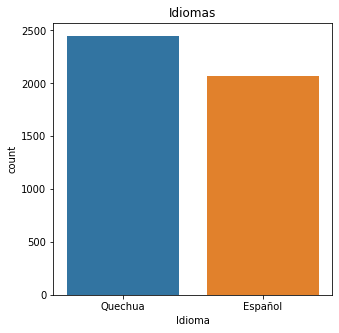

In [ ]:
f, ax = plt.subplots(figsize=(5,5))
sns.countplot(x='Idioma', data = df)
plt.title('Idiomas')
plt.show()

### Visualizacion wordCloud Espaniol / Quechua

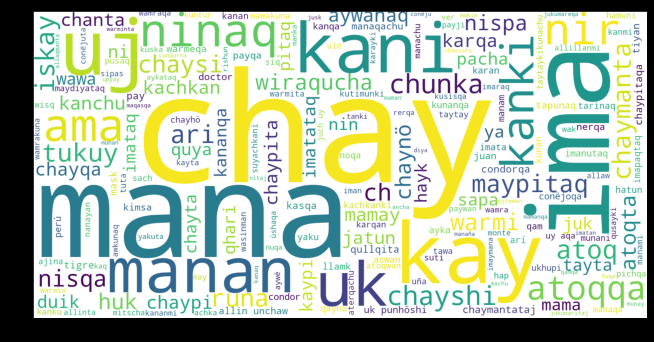

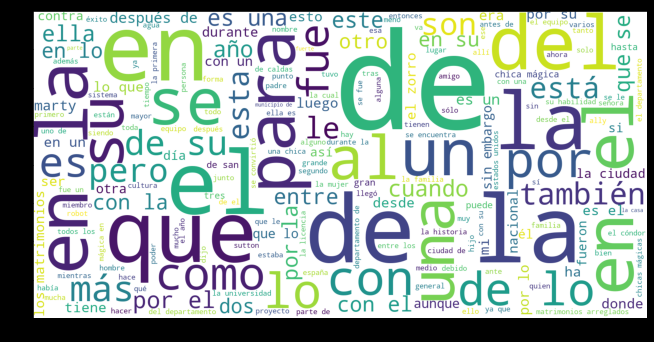

In [ ]:
def generar_wordcloud(data):
  wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(data))
  plt.figure( figsize=(11,7), facecolor='k')
  plt.imshow(wordcloud)

generar_wordcloud(df[df.Idioma=='Quechua']['Texto'].tolist())
generar_wordcloud(df[df.Idioma=='Español']['Texto'].tolist())

### Visualizacion de la frecuencia de vocales segun el idioma

In [ ]:
df['A'] = df.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'a'), axis=1)
df['E'] = df.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'e'), axis=1)
df['I'] = df.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'i'), axis=1)
df['O'] = df.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'o'), axis=1)
df['U'] = df.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'u'), axis=1)

Se hace una copia del dataFrame con fines de visualización

In [ ]:
df1 = df.copy()
df1["Text_size"] = df1['Texto'].apply(len)
df1['A']=df1['A']/df1['Text_size']
df1['E']=df1['E']/df1['Text_size']
df1['I']=df1['I']/df1['Text_size']
df1['O']=df1['O']/df1['Text_size']
df1['U']=df1['U']/df1['Text_size']
df1.head()

,Texto,Idioma,A,E,I,O,U,Text_size
0,makiykita paqakuy manaraq sirbanaykipaq,Quechua,0.256410,0.000000,0.102564,0.000000,0.025641,39
1,pipaqtaq,Quechua,0.250000,0.000000,0.125000,0.000000,0.000000,8
2,dónde sucedió el accidente,Español,0.038462,0.192308,0.076923,0.000000,0.038462,26
3,wasimasiypa wakankunan chayta ruwanku,Quechua,0.243243,0.000000,0.054054,0.000000,0.081081,37
4,todos le tenemos miedo,Español,0.000000,0.181818,0.045455,0.181818,0.000000,22


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

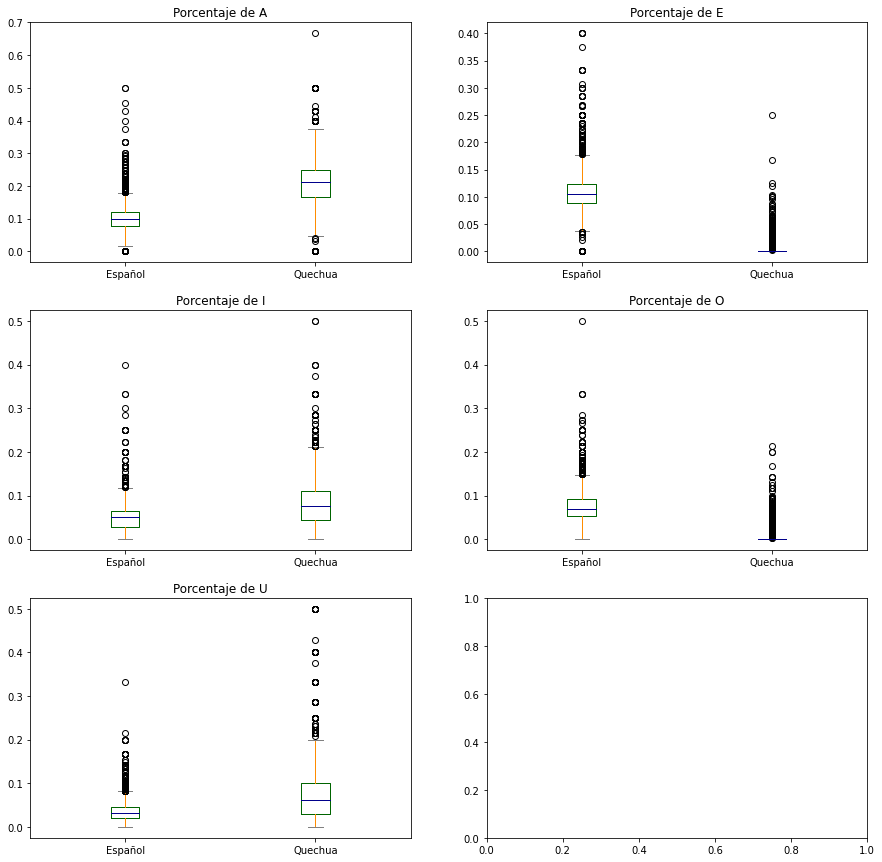

In [ ]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
fig, axes = plt.subplots(3, 2, figsize=(15,15))
df1.pivot(columns='Idioma').A.plot(kind = 'box', stacked=False, color=color, title='Porcentaje de A', ax=axes[0,0])
df1.pivot(columns='Idioma').E.plot(kind = 'box', stacked=False, color=color, title='Porcentaje de E', ax=axes[0,1])
df1.pivot(columns='Idioma').I.plot(kind = 'box', stacked=False, color=color, title='Porcentaje de I', ax=axes[1,0])
df1.pivot(columns='Idioma').O.plot(kind = 'box', stacked=False, color=color, title='Porcentaje de O', ax=axes[1,1])
df1.pivot(columns='Idioma').U.plot(kind = 'box', stacked=False, color=color, title='Porcentaje de U', ax=axes[2,0])

### Visualización de caracteres

Text(0.5, 1.0, 'Cantidad de R')

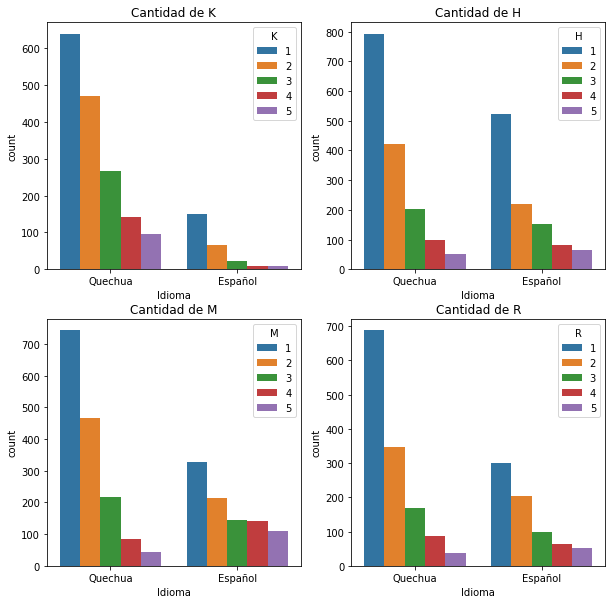

In [ ]:
df1['K'] = df.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'k'), axis=1)
df1['H'] = df.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'h'), axis=1)
df1['M'] = df.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'm'), axis=1)
df1['R'] = df.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'r'), axis=1)
fig, axes = plt.subplots(2, 2, figsize=(10,10))
sns.countplot(x='Idioma', hue='K', data=df1, hue_order=[1,2,3,4,5], ax=axes[0,0])
sns.countplot(x='Idioma', hue='H', data=df1, hue_order=[1,2,3,4,5], ax=axes[0,1])
sns.countplot(x='Idioma', hue='M', data=df1, hue_order=[1,2,3,4,5], ax=axes[1,0])
sns.countplot(x='Idioma', hue='R', data=df1, hue_order=[1,2,3,4,5], ax=axes[1,1])
axes[0, 0].set_title("Cantidad de K")
axes[0, 1].set_title("Cantidad de H")
axes[1, 0].set_title("Cantidad de M")
axes[1, 1].set_title("Cantidad de R")

### Visualización de caracteres especiales

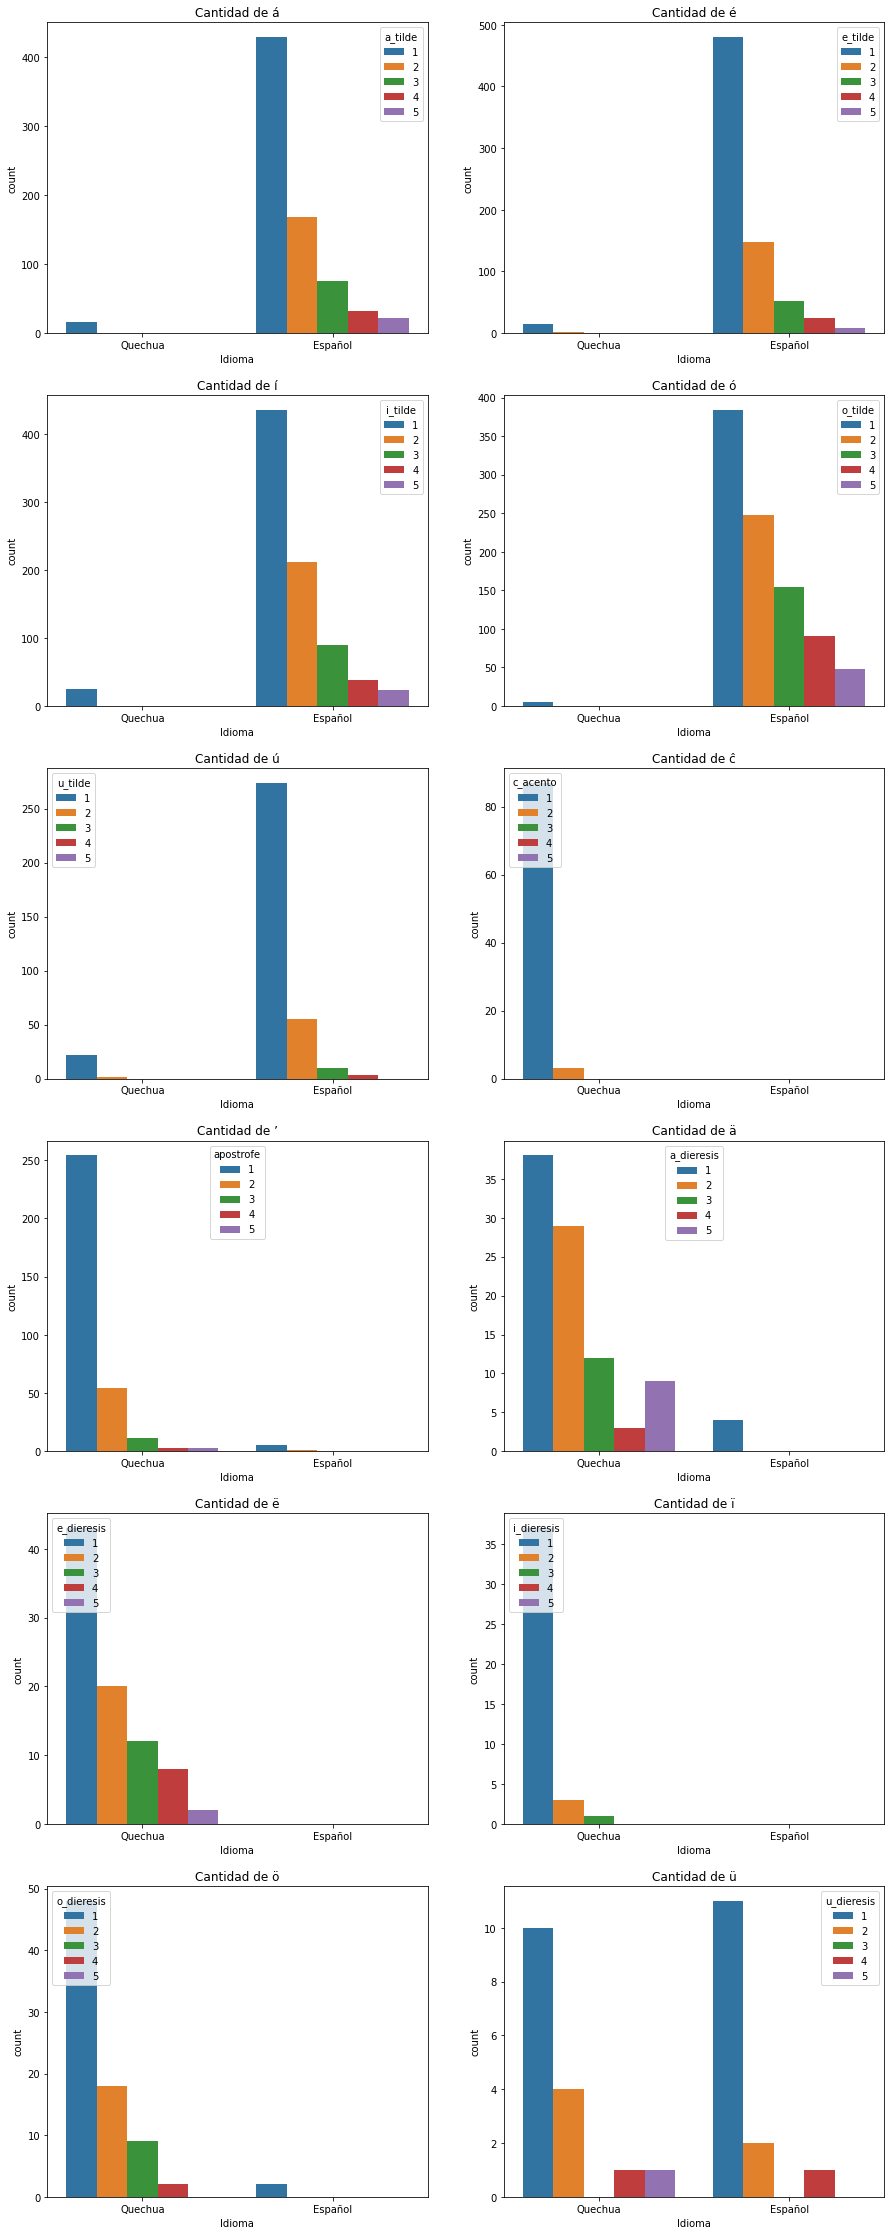

In [ ]:
df1['a_tilde'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'á'), axis=1)
df1['e_tilde'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'é'), axis=1)
df1['i_tilde'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'í'), axis=1)
df1['o_tilde'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'ó'), axis=1)
df1['u_tilde'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'ú'), axis=1)
df1['c_acento'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'ĉ'), axis=1)
df1['apostrofe'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'’'), axis=1)
df1['a_dieresis'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'ä'), axis=1)
df1['e_dieresis'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'ë'), axis=1)
df1['i_dieresis'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'ï'), axis=1)
df1['o_dieresis'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'ö'), axis=1)
df1['u_dieresis'] = df1.apply(lambda x: contar_frecuencia_regex(x['Texto'], r'ü'), axis=1)
fig, axes = plt.subplots(6, 2, figsize=(15,40))
sns.countplot(x='Idioma', hue='a_tilde', data=df1, hue_order=[1,2,3,4,5], ax=axes[0,0])
sns.countplot(x='Idioma', hue='e_tilde', data=df1, hue_order=[1,2,3,4,5], ax=axes[0,1])
sns.countplot(x='Idioma', hue='i_tilde', data=df1, hue_order=[1,2,3,4,5], ax=axes[1,0])
sns.countplot(x='Idioma', hue='o_tilde', data=df1, hue_order=[1,2,3,4,5], ax=axes[1,1])
sns.countplot(x='Idioma', hue='u_tilde', data=df1, hue_order=[1,2,3,4,5], ax=axes[2,0])
sns.countplot(x='Idioma', hue='c_acento', data=df1, hue_order=[1,2,3,4,5], ax=axes[2,1])
sns.countplot(x='Idioma', hue='apostrofe', data=df1, hue_order=[1,2,3,4,5], ax=axes[3,0])
sns.countplot(x='Idioma', hue='a_dieresis', data=df1, hue_order=[1,2,3,4,5], ax=axes[3,1])
sns.countplot(x='Idioma', hue='e_dieresis', data=df1, hue_order=[1,2,3,4,5], ax=axes[4,0])
sns.countplot(x='Idioma', hue='i_dieresis', data=df1, hue_order=[1,2,3,4,5], ax=axes[4,1])
sns.countplot(x='Idioma', hue='o_dieresis', data=df1, hue_order=[1,2,3,4,5], ax=axes[5,0])
sns.countplot(x='Idioma', hue='u_dieresis', data=df1, hue_order=[1,2,3,4,5], ax=axes[5,1])
axes[0, 0].set_title("Cantidad de á")
axes[0, 1].set_title("Cantidad de é")
axes[1, 0].set_title("Cantidad de í")
axes[1, 1].set_title("Cantidad de ó")
axes[2, 0].set_title("Cantidad de ú")
axes[2, 1].set_title("Cantidad de ĉ")
axes[3, 0].set_title("Cantidad de ’")
axes[3, 1].set_title("Cantidad de ä")
axes[4, 0].set_title("Cantidad de ë")
axes[4, 1].set_title("Cantidad de ï")
axes[5, 0].set_title("Cantidad de ö")
axes[5, 1].set_title("Cantidad de ü")
plt.show()

## Vectorizacion de las features

El texto es vectorizado segun los caracteres que contiene

In [ ]:
ngram_vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 5))
X_vector = ngram_vectorizer.fit_transform(df['Texto']).toarray()

In [ ]:
np.array(ngram_vectorizer.get_feature_names())[:20]

array([' ', ' ^', ' ^ ', ' ^ e', ' ^ em', ' ^ r', ' ^ ro', ' ^ s',
       ' ^ se', ' a', ' a ', ' a a', ' a a ', ' a ab', ' a ac', ' a ad',
       ' a ag', ' a aj', ' a al', ' a am'], dtype='<U5')

In [ ]:
# Calcular la frecuencia de los caracteres
transformer = TfidfTransformer()
X = transformer.fit_transform(X_vector)

In [ ]:
X.toarray()

array([[0.05036229, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06817436, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0207012 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.23142872, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28219166, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
df['Idioma'].tail() # quechua 1 / espaniol 0

4511    Español
4512    Quechua
4513    Quechua
4514    Español
4515    Español
Name: Idioma, dtype: object

In [ ]:
# Convertir en valor numerico los targets
le = LabelEncoder()
y = df['Idioma']
y = le.fit_transform(y)
y

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
# Separar las caracteristicas (features) del objetivo (target)
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.3, random_state=18)

# Generacion de modelos

# Naive Bayes

In [ ]:
param_multinomial = {'alpha': [0, 1.0], 
              'fit_prior': [True, False],
              'class_prior': [1, 2, None]} 
  
multinomial = GridSearchCV(MultinomialNB(), param_multinomial, refit = True)

multinomial.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'int' has no len()

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'int' has no len()

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:

GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0, 1.0], 'class_prior': [1, 2, None],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# imprime los mejores parametros obtenidos usando GridSearch
print(multinomial.best_params_)

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


In [ ]:
# Entrenar el modelo con los mejore parametros
multinomial_model = multinomial.best_estimator_
multinomial_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Support Vector Machine

In [ ]:
# definir los rangos de los parametros
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0)

grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# imprime los mejores parametros
print(grid.best_params_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
svm_model = grid.best_estimator_
# svm_model = SVC(C=100, gamma=0.01, kernel='rbf', probability=True)
svm_model.probability = True
svm_model.fit(X_train, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

# Logistic Regression

In [ ]:
params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
grid1 = GridSearchCV(LogisticRegression(), params, cv=5)

# Entrenar el modelo con los mejores parametros
grid1.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_se

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# Imprime los mejores parametros
print(grid1.best_params_)

{'C': 10.0, 'penalty': 'l2'}


In [ ]:
log_reg = grid1.best_estimator_
# log_reg = LogisticRegression(C=1000.0, penalty='l2')
log_reg.fit(X_train,y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Decision Tree Classifier

In [ ]:
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [ ]:
# print best parameter after tuning
print(clf.best_params_)

{'criterion': 'gini', 'max_depth': 5}


In [ ]:
# Entrenar el modelo con los mejores parametros
model_tree = clf.best_estimator_
# model_tree = DecisionTreeClassifier(criterion='entropy', max_depth=12)
model_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Evaluacion de los modelos

In [ ]:
def evaluar_modelo(modelo, nombre):
  start = time()
  # predecir resultados con el conjunto test
  prediccion = modelo.predict(X_test)
  print(f'Tiempo de ejecucion: {time() - start} segundos')
  # imprimir reporte de la clasificacion
  print('Accuracy de ', nombre, 'es: ', accuracy_score(prediccion, y_test))
  print('Balanced Accuracy de ', nombre, 'es: ', balanced_accuracy_score(prediccion, y_test))
  print(classification_report(y_test, prediccion))
  # graficar la matriz de confusion
  cm = confusion_matrix(y_test, prediccion)
  plt.figure()
  sns.heatmap(cm, annot=True, annot_kws={"size":30}, fmt='g', cmap='Blues')
  plt.show()

In [ ]:
def graficar_roc(modelo, nombre):
  #Generamos un clasificador sin entrenar , que asignará 0 a todo
  ns_probs = [0 for _ in range(len(y_test))]
  # Predecimos las probabilidades
  lr_probs = modelo.predict_proba(X_test)
  #Nos quedamos con las probabilidades de la clase positiva (la probabilidad de 1)
  lr_probs = lr_probs[:, 1]
  # Calculamos el AUC
  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)
  # Imprimimos en pantalla
  print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
  print(nombre+': ROC AUC=%.3f' % (lr_auc))
  # Calculamos las curvas ROC
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
  # Pintamos las curvas ROC
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
  plt.plot(lr_fpr, lr_tpr, marker='.', label=nombre)
  # Etiquetas de los ejes
  plt.xlabel('Tasa de Falsos Positivos')
  plt.ylabel('Tasa de Verdaderos Positvos')
  plt.title('CURVA DE ROC - '+ nombre)
  plt.legend()
  plt.show()

In [ ]:
def graficar_curva_aprendizaje(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

========= Multinomial Naive Bayes ==========
Tiempo de ejecucion: 0.010808467864990234 segundos
Accuracy de  Multinomial Naive Bayes es:  0.988929889298893
Balanced Accuracy de  Multinomial Naive Bayes es:  0.9884271999021587
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       631
           1       1.00      0.98      0.99       724

    accuracy                           0.99      1355
   macro avg       0.99      0.99      0.99      1355
weighted avg       0.99      0.99      0.99      1355



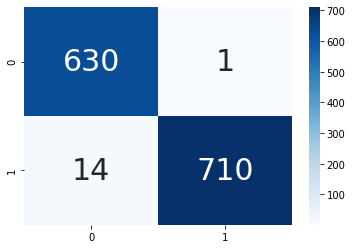

In [ ]:
print("========= Multinomial Naive Bayes ==========")
evaluar_modelo(multinomial_model, 'Multinomial Naive Bayes')

Sin entrenar: ROC AUC=0.500
Multinomial Naive Bayes: ROC AUC=1.000


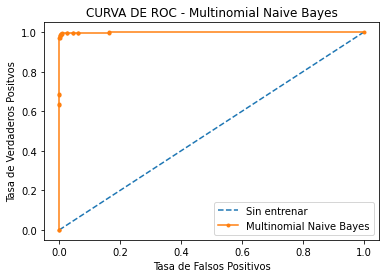

In [ ]:
graficar_roc(multinomial_model, 'Multinomial Naive Bayes')

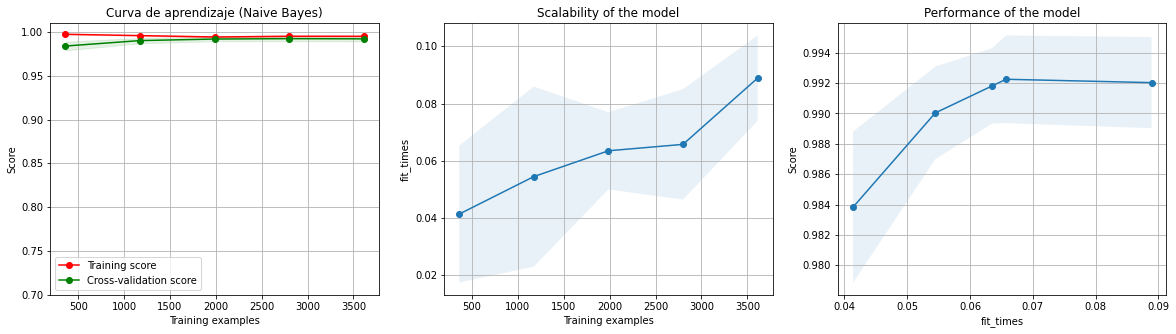

In [ ]:
title = "Curva de aprendizaje (Naive Bayes)"
graficar_curva_aprendizaje(multinomial_model, title, X, y, axes=None, ylim=(0.7, 1.01), n_jobs=4)
plt.show()

========= SVM ==========
Tiempo de ejecucion: 0.7275874614715576 segundos
Accuracy de  SVM es:  0.9948339483394834
Balanced Accuracy de  SVM es:  0.9947607542412942
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       631
           1       1.00      0.99      1.00       724

    accuracy                           0.99      1355
   macro avg       0.99      0.99      0.99      1355
weighted avg       0.99      0.99      0.99      1355



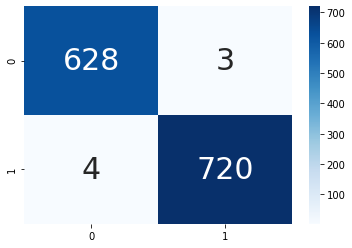

In [ ]:
print("========= SVM ==========")
evaluar_modelo(svm_model, 'SVM')

Sin entrenar: ROC AUC=0.500
SVM: ROC AUC=1.000


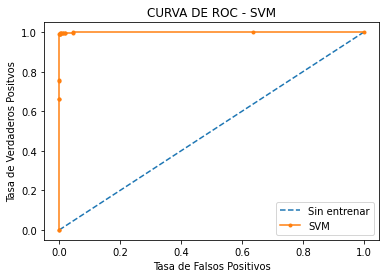

In [ ]:
graficar_roc(svm_model, 'SVM')

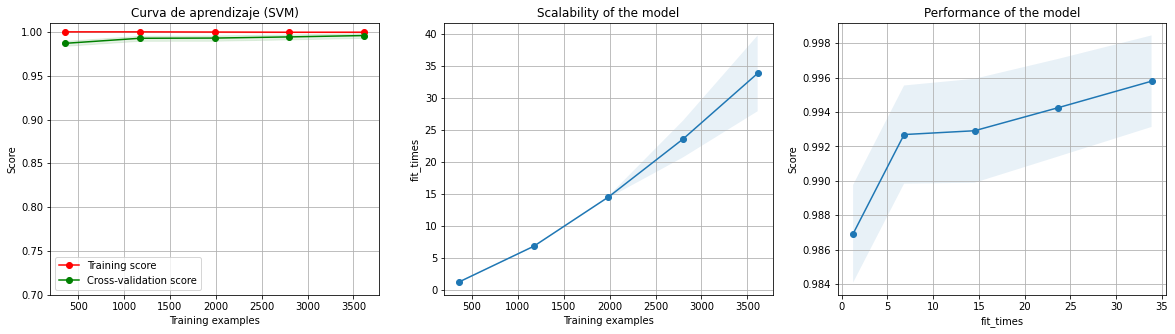

In [ ]:
title = "Curva de aprendizaje (SVM)"
graficar_curva_aprendizaje(svm_model, title, X, y, axes=None, ylim=(0.7, 1.01), n_jobs=4)
plt.show()

========= Logistic Regression ==========
Tiempo de ejecucion: 0.0029757022857666016 segundos
Accuracy de  Logistic Regression es:  0.992619926199262
Balanced Accuracy de  Logistic Regression es:  0.9926881183565676
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       631
           1       0.99      0.99      0.99       724

    accuracy                           0.99      1355
   macro avg       0.99      0.99      0.99      1355
weighted avg       0.99      0.99      0.99      1355



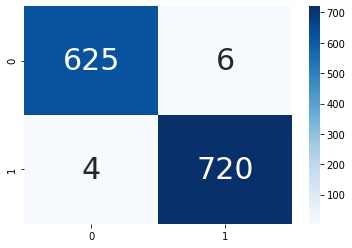

In [ ]:
print("========= Logistic Regression ==========")
evaluar_modelo(log_reg, 'Logistic Regression')

Sin entrenar: ROC AUC=0.500
Logistic Regression: ROC AUC=1.000


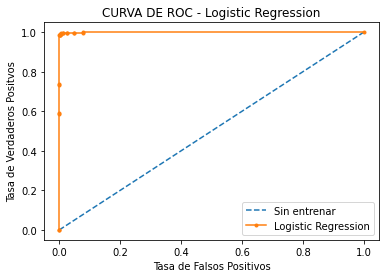

In [ ]:
graficar_roc(log_reg, 'Logistic Regression')

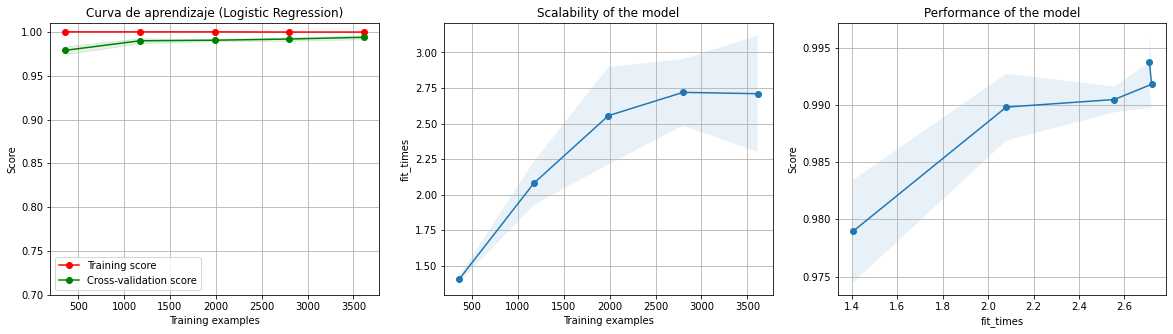

In [ ]:
title = "Curva de aprendizaje (Logistic Regression)"
graficar_curva_aprendizaje(log_reg, title, X, y, axes=None, ylim=(0.7, 1.01), n_jobs=4)
plt.show()

========= Arboles de Decision ==========
Tiempo de ejecucion: 0.0063245296478271484 segundos
Accuracy de  Decision Tree es:  0.9837638376383764
Balanced Accuracy de  Decision Tree es:  0.9838943950786057
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       631
           1       0.98      0.99      0.98       724

    accuracy                           0.98      1355
   macro avg       0.98      0.98      0.98      1355
weighted avg       0.98      0.98      0.98      1355



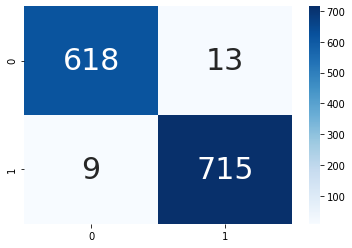

In [ ]:
print("========= Arboles de Decision ==========")
evaluar_modelo(model_tree, 'Decision Tree')

Sin entrenar: ROC AUC=0.500
Decision Tree: ROC AUC=0.981


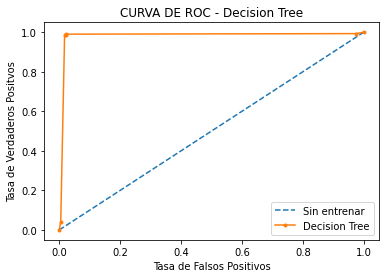

In [ ]:
graficar_roc(model_tree, 'Decision Tree')

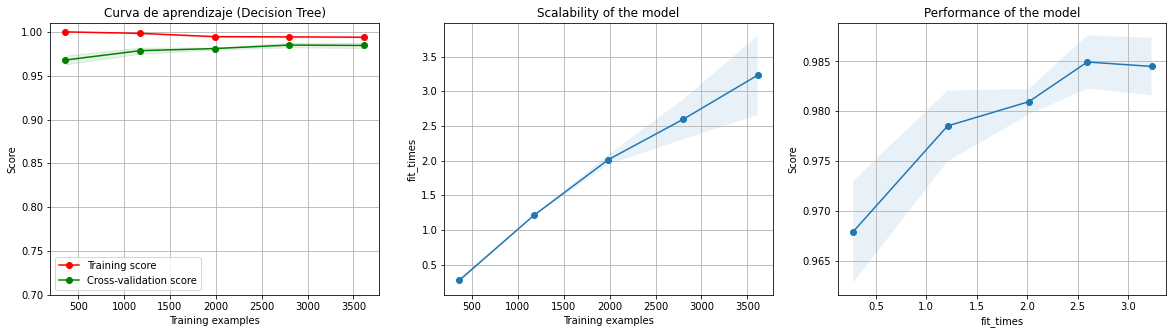

In [ ]:
title = "Curva de aprendizaje (Decision Tree)"
graficar_curva_aprendizaje(model_tree, title, X, y, axes=None, ylim=(0.7, 1.01), n_jobs=4)
plt.show()

# Predicción con nuevos datos

In [ ]:
def preprocesar(texto, vectorizer, transformer):
    nuevo_texto = reemplazar_caracteres_diferentes(texto, dict_reemplazo)
    nuevo_texto = nuevo_texto.lower()
    nuevo_texto = eliminar_ruido(nuevo_texto, [r'[^\w\s^\´\’]'])
    nuevo_texto = eliminar_espacios(nuevo_texto)
    if len(nuevo_texto) < 0:
      raise Exception('Frase invalida!')
    vector = vectorizer.transform([nuevo_texto])
    vector = transformer.transform(vector)
    return vector

In [ ]:
modelo_seleccionado = log_reg

## Predecir nuevos datos

In [ ]:
#@title Ingresa una frase para predecir su idioma
frase = "Manan imapis mana atinaqa kanchu" #@param {type:"string"}
try:
  if len(frase) > 0:
    input = preprocesar(frase, ngram_vectorizer, transformer)
    predicted = modelo_seleccionado.predict(input)
    if predicted==1:
      target = 'Quechua'
    else:
      target = 'Español'
    print(f"El idioma del texto es: {target}")
  else:
    raise Exception('Frase invalida!')
except Exception as e:
  print("Ingresa una frase valida, la frase que ingreso es invalida")

El idioma del texto es: Quechua
